# Introduction to Semantic Kernel Agents

Welcome to this workshop on Semantic Kernel (SK) agents! In this notebook, we'll explore how to create, configure, and use agents with the Semantic Kernel framework.

## What You'll Learn
- What agents are in Semantic Kernel
- How to create and configure different types of agents
- Basic and advanced interaction patterns with agents
- How to integrate plugins and functions with agents
- Multi-agent systems and orchestration

Let's start by setting up our environment and understanding the foundational concepts of Semantic Kernel agents.

## 1. Introduction to Semantic Kernel Agents

### What are agents in Semantic Kernel?

In Semantic Kernel, an **agent** is a specialized component that can interact with Large Language Models (LLMs), process conversations, make decisions, and potentially execute code or call functions. Unlike simple prompt-based interactions, agents maintain state, follow instructions, and can engage in multi-turn conversations to accomplish tasks.

At their core, agents are designed to:
- Process user inputs and generate contextual responses
- Maintain conversation history and context
- Execute functions when appropriate (function calling)
- Work independently or collaborate with other agents

### Agent Architecture in Semantic Kernel

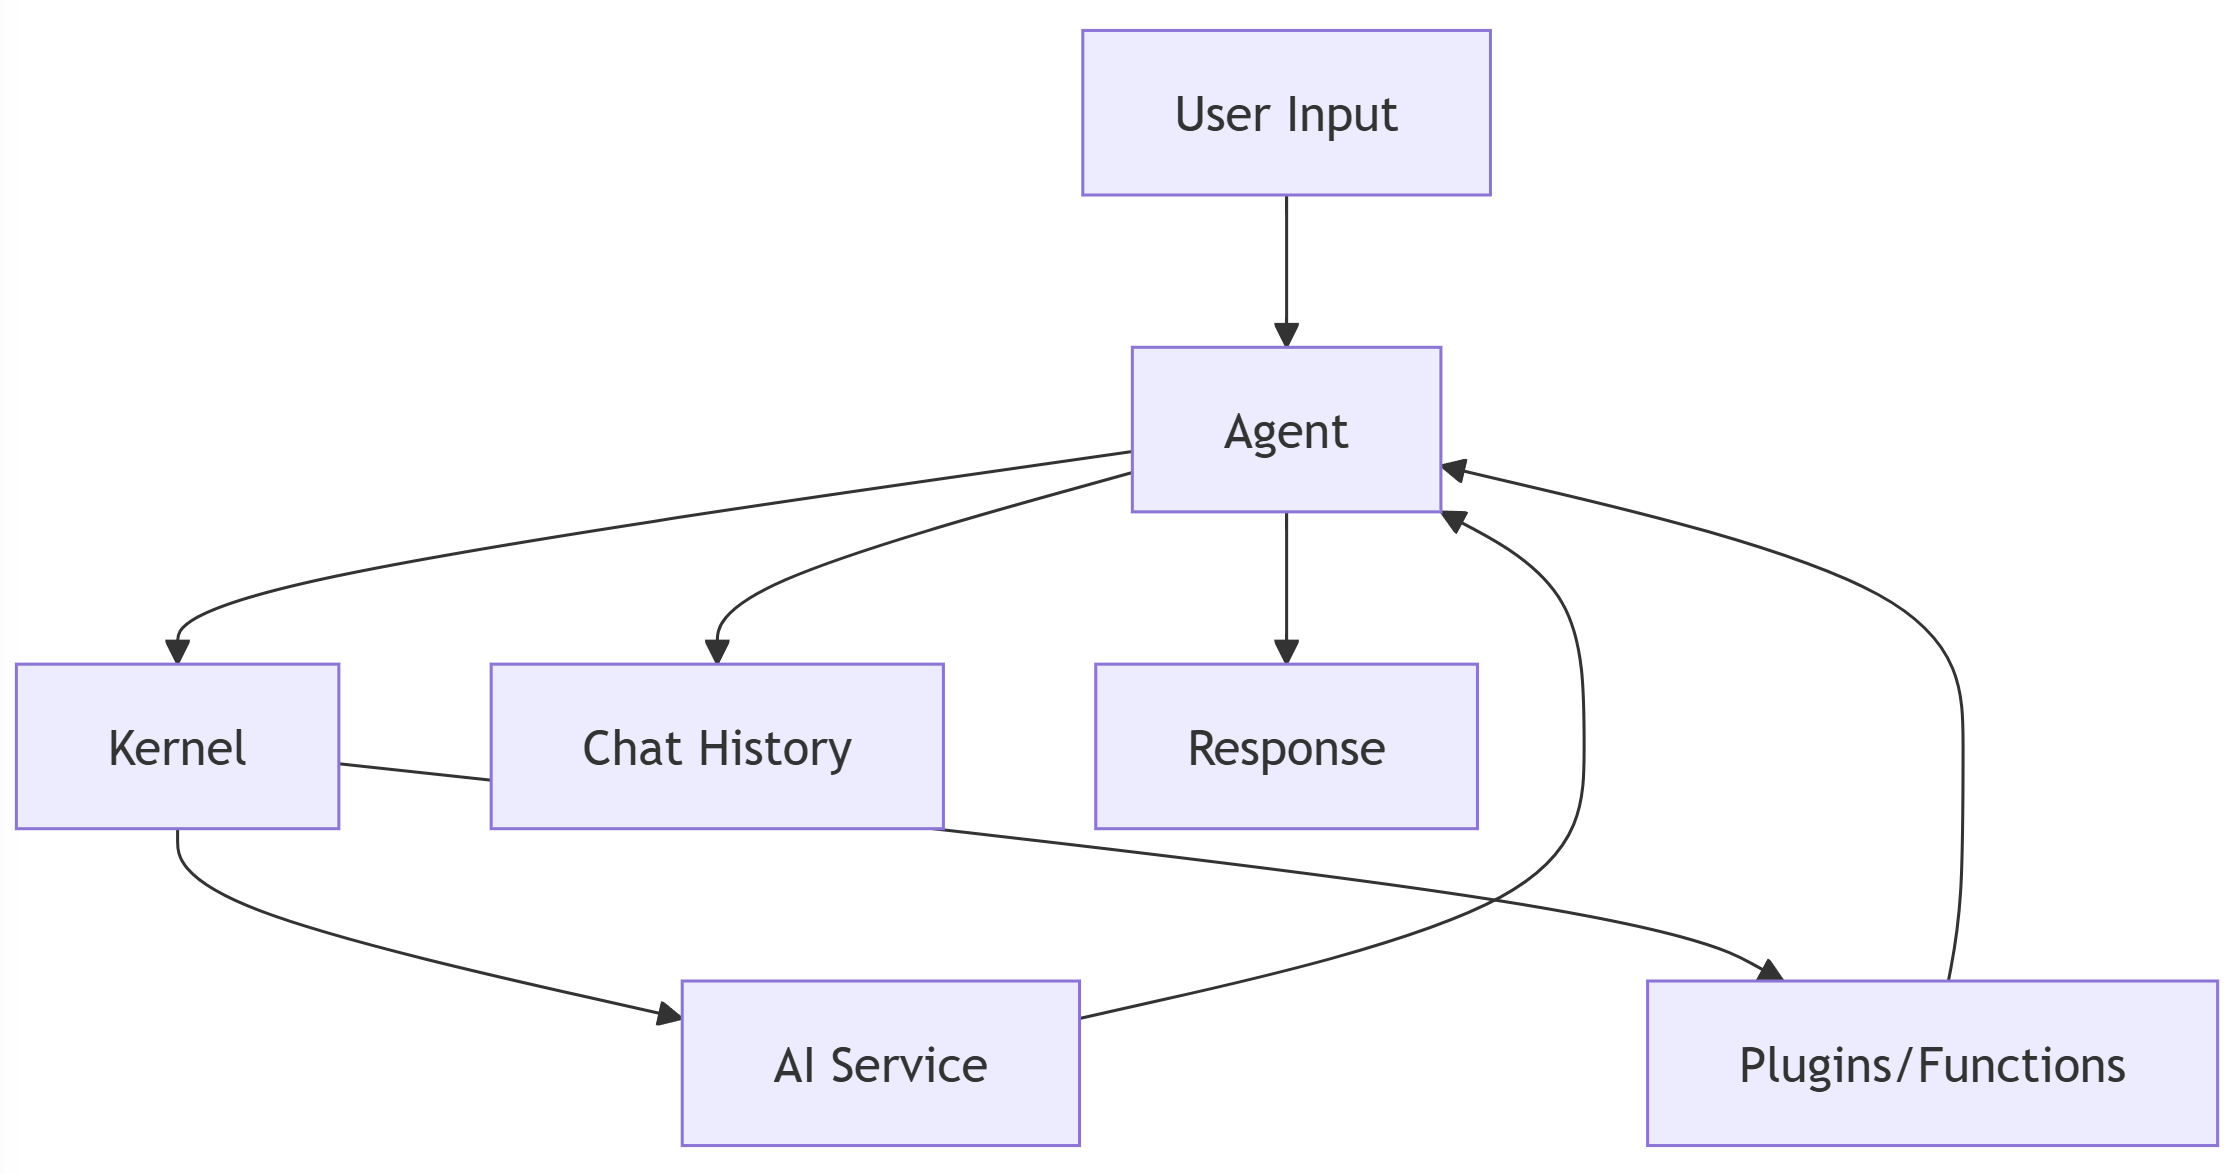

Key components in the agent architecture:

1. **Kernel**: The core orchestration engine that connects agents to AI services and functions
2. **AI Service**: The underlying LLM that powers the agent (like Azure OpenAI, OpenAI)
3. **Chat History**: Maintains the conversation context over multiple turns
4. **Plugins/Functions**: Optional extensions that allow the agent to perform specific tasks

### Types of Agents in Semantic Kernel

Semantic Kernel primarily offers two types of agents:

1. **ChatCompletionAgent**
   - Lightweight agent that uses your kernel's chat completion service
   - Good for simple conversational tasks
   - Manages chat history locally

2. **OpenAIAssistantAgent / AzureAssistantAgent**
   - Uses OpenAI's Assistant API
   - Maintains conversation state remotely as "threads"
   - Supports advanced features like code interpretation and file searching
   - Requires explicit thread management

Let's first install the necessary packages to work with Semantic Kernel agents:

In [ ]:
# Install required packages
# !pip install semantic-kernel python-dotenv==1.0.1 rich

Now, let's set up our environment by loading environment variables and importing the necessary modules:

In [66]:
import os
import asyncio
from dotenv import load_dotenv

# Import Semantic Kernel components
import semantic_kernel as sk
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    OpenAIChatCompletion,
)
from semantic_kernel.contents import ChatHistory, ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions import KernelArguments

from semantic_kernel.contents.function_call_content import FunctionCallContent
from semantic_kernel.contents.function_result_content import FunctionResultContent

from semantic_kernel.agents import (
    ChatCompletionAgent,
    ChatHistoryAgentThread,
)

from rich.console import Console
console = Console()

# Load environment variables from .env file
load_dotenv("../.env", override=True)

True

For this workshop, we'll need to set up our environment variables with either Azure OpenAI or OpenAI credentials. You can create a `.env` file in the same directory as this notebook with the following variables:

```
# For Azure OpenAI
AZURE_OPENAI_ENDPOINT="https://your-resource-name.openai.azure.com/"
AZURE_OPENAI_API_KEY="your-azure-openai-api-key"
AZURE_OPENAI_DEPLOYMENT_NAME="your-deployment-name"

# For OpenAI
OPENAI_API_KEY="your-openai-api-key"
```

Let's now create a helper function that will configure a kernel with the appropriate AI service based on the available credentials:

In [2]:
def create_kernel_with_service(service_id="default"):
    """Create a kernel with either Azure OpenAI or OpenAI service based on available credentials."""
    kernel = sk.Kernel()

    # Try to use Azure OpenAI first
    if (
        os.getenv("AZURE_OPENAI_API_KEY")
        and os.getenv("AZURE_OPENAI_ENDPOINT")
        and os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
    ):
        print("Using Azure OpenAI service")
        kernel.add_service(
            AzureChatCompletion(
                service_id=service_id,
                deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
                endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            )
        )
    # Fall back to OpenAI
    elif os.getenv("OPENAI_API_KEY"):
        print("Using OpenAI service")
        kernel.add_service(
            OpenAIChatCompletion(
                service_id=service_id,
                api_key=os.getenv("OPENAI_API_KEY"),
                ai_model_id="gpt-4",
            )
        )
    else:
        raise ValueError(
            "No AI service credentials found. Please set up your .env file."
        )

    return kernel

## 2. Setting Up Your Environment

Now that we understand what agents are and have imported the necessary modules, let's begin by creating our first kernel instance and configuring the environment properly.

### Creating a Kernel Instance

The `Kernel` is the central orchestration component in Semantic Kernel. It manages AI services, plugins, and other resources that agents need to function. Let's create our first kernel:

In [3]:
# Create our first kernel with a service ID
kernel = create_kernel_with_service(service_id="chat-completion")
print("Kernel created successfully!")

Using Azure OpenAI service
Kernel created successfully!


### Understanding Service Configuration

When adding an AI service to the kernel, we specified a `service_id`. This ID is important because:

1. It allows you to add multiple services to the same kernel
2. You can selectively use different services for different agents
3. It helps organize and identify your services

If you need specific execution settings for your AI service (like temperature, top-p, or function calling behavior), you can retrieve and modify them:

In [4]:
# Get the execution settings for our service
settings = kernel.get_prompt_execution_settings_from_service_id(
    service_id="chat-completion"
)

## Set the service settings for the agent
using_gpt_4o = True

# Example: Adjust the temperature for more creative outputs -- NOTE: RUN THE BELOW ONLY IF YOU ARE USING GPT-4o
if using_gpt_4o:
    settings.temperature = 0.7
    print(f"Service settings updated: Temperature set to {settings.temperature}")
else:  # NOTE: RUN THE BELOW ONLY IF YOU ARE USING o1 or o3-mini
    settings.reasoning_effort = "low"
    print(
        f"Service settings updated: Reasoning Effort set to {settings.reasoning_effort}"
    )

Service settings updated: Temperature set to 0.7


### Exercise: Create Multiple Services in a Kernel

In this exercise, try creating a kernel with two different AI services with different configurations. This will be useful when we want to use different services for different agents or functions.

Your task:
1. Create a new kernel
2. Add two services with different service IDs (e.g., "creative" and "precise")
3. Configure the "creative" service with higher temperature (e.g., 0.8)
4. Configure the "precise" service with lower temperature (e.g., 0.2)

In [ ]:
# Your code here to create a kernel with multiple services

# First, create the kernel

# Then add two services with different configurations

# Finally, retrieve and modify settings for each service

<details>
<summary>Click to see solution</summary>

```python
# Create a new kernel for multiple services
multi_service_kernel = sk.Kernel()

# Add first service - creative with higher temperature
if os.getenv("AZURE_OPENAI_API_KEY"):
    multi_service_kernel.add_service(
        AzureChatCompletion(
            service_id="creative",
            deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
            endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
            api_key=os.getenv("AZURE_OPENAI_API_KEY")
        )
    )
    
    # Add second service - precise with lower temperature
    multi_service_kernel.add_service(
        AzureChatCompletion(
            service_id="precise",
            deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
            endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
            api_key=os.getenv("AZURE_OPENAI_API_KEY")
        )
    )
elif os.getenv("OPENAI_API_KEY"):
    multi_service_kernel.add_service(
        OpenAIChatCompletion(
            service_id="creative",
            api_key=os.getenv("OPENAI_API_KEY"),
            model_id="gpt-4"
        )
    )
    
    multi_service_kernel.add_service(
        OpenAIChatCompletion(
            service_id="precise",
            api_key=os.getenv("OPENAI_API_KEY"),
            model_id="gpt-4"
        )
    )
else:
    print("No AI service credentials found. Please set up your .env file.")

# Configure the settings for each service
creative_settings = multi_service_kernel.get_prompt_execution_settings_from_service_id(service_id="creative")
creative_settings.temperature = 0.8
print(f"Creative service temperature: {creative_settings.temperature}")

precise_settings = multi_service_kernel.get_prompt_execution_settings_from_service_id(service_id="precise")
precise_settings.temperature = 0.2
print(f"Precise service temperature: {precise_settings.temperature}")
```
</details>

### Key Takeaways

In this section, we've learned how to:

1. **Set up our environment** with necessary imports and credentials
2. **Create a kernel** as the foundation for our agents
3. **Configure AI services** with specific IDs and settings
4. **Manage execution settings** to control how the AI generates responses

In the next section, we'll create our first agent using the kernel we've just configured.

## 3. Your First Agent: ChatCompletionAgent

Now that we have our kernel and services set up, let's create our first agent. We'll start with the `ChatCompletionAgent`, which is a simple yet powerful agent that leverages the chat completion capabilities of large language models.

### Creating a Basic Agent

To create a `ChatCompletionAgent`, we need to provide:
1. A kernel with a configured chat service
2. Instructions that define the agent's behavior
3. Optional parameters like a name and execution settings

Let's create a simple assistant agent:

In [5]:
# Create a simple assistant agent
assistant_agent = ChatCompletionAgent(
    kernel=kernel,
    name="Assistant",
    instructions="You are a helpful assistant that provides concise and accurate information. Keep your responses brief but informative.",
)

print(f"Agent '{assistant_agent.name}' created successfully!")

Agent 'Assistant' created successfully!


### Configuring Instructions and Parameters

The `instructions` parameter is crucial as it defines how your agent will behave. Think of it as the "system prompt" that shapes the agent's personality, capabilities, and limitations. Let's explore some more complex instructions:

In [6]:
# Create a specialized agent with detailed instructions
math_tutor_agent = ChatCompletionAgent(
    kernel=kernel,
    name="MathTutor",
    instructions="""You are a math tutor specialized in helping students understand mathematical concepts.
    
    When responding to questions:
    1. First explain the underlying concept in simple terms
    2. Then walk through the solution step by step
    3. Provide a simple example to reinforce the learning
    4. Avoid solving problems directly without explanation
    
    Always be encouraging and patient.
    """,
)

print(f"Agent '{math_tutor_agent.name}' created with specialized instructions.")

Agent 'MathTutor' created with specialized instructions.


### Dynamic Instructions with Template Parameters

You can make your agent's instructions dynamic by including template parameters. These parameters get replaced with actual values when the agent is invoked. This is useful for creating agents that need context that might change, like the current date or user preferences.

In [7]:
# Create an agent with template parameters in instructions
templated_agent = ChatCompletionAgent(
    kernel=kernel,
    name="TemplatedAgent",
    instructions="""You are an AI assistant specializing in {{$expertise}}.
    Your tone should be {{$tone}} and your responses should be {{$length}} in length.
    
    Today's date is: {{$current_date}}
    """,
    arguments=KernelArguments(
        expertise="Python programming",
        tone="friendly",
        length="concise",
        current_date="2024-03-14",  # This could be dynamically set when invoking
    ),
)

print(f"Agent '{templated_agent.name}' created with template parameters.")

Agent 'TemplatedAgent' created with template parameters.


### Understanding Agent Execution

Once an agent is created, it needs a chat history to interact with. The chat history maintains the state of the conversation and provides context for the agent's responses.

Here's a simple example of how to execute an agent:

In [8]:
# Create a chat history to maintain conversation state
chat_history = ChatHistory()

# Add a user message to the chat history
chat_history.add_message(
    ChatMessageContent(
        role=AuthorRole.USER, content="Hello! Can you introduce yourself?"
    )
)


# Define a function to execute the agent asynchronously
async def get_agent_response(agent, history):
    # Get a single response from the agent
    response = await agent.get_response(messages=history)
    
    return response


# Execute the agent
response = await get_agent_response(assistant_agent, chat_history)

# Print the agent's response
print(f"Agent: {response.content}")

Agent: Hello! I’m ChatGPT, an AI language model created by OpenAI. I can answer questions, assist with writing, help with learning, and provide information on a wide range of topics. How can I help you today?


There are actually three main ways to invoke an agent:

1. **`get_response()`**: Returns a single response directly as a `ChatMessageContent` object
2. **`invoke()`**: Returns an async iterable of `ChatMessageContent` objects
3. **`invoke_stream()`**: Streams the response in real-time (useful for long responses)

Let's see how `invoke()` works:

In [9]:
# Create a new chat history
chat_history = ChatHistory()
chat_history.add_message(
    ChatMessageContent(
        role=AuthorRole.USER, content="What can you tell me about quantum computing?"
    )
)


# Define a function to invoke the agent using invoke()
async def invoke_agent(agent, history):
    responses = []
    # Iterate through the responses asynchronously
    async for response in agent.invoke(messages=history):
        responses.append(response)
    return responses


# Execute the agent
responses = await invoke_agent(assistant_agent, chat_history)

# Print the responses
for i, response in enumerate(responses):
    print(f"Response {i + 1}: {str(response.content)[:100]}...")

Response 1: Quantum computing is an emerging field that uses the principles of quantum mechanics to perform comp...


### Exercise: Implement a Simple Question-Answering Agent

Now it's your turn to create a custom agent. Implement a question-answering agent that specializes in providing factual information about a specific topic of your choice.

Your task:
1. Create a new `ChatCompletionAgent` with a descriptive name
2. Configure it with detailed instructions that define its area of expertise and how it should respond
3. Create a chat history with a relevant question
4. Execute the agent and display its response

In [ ]:
# Your code here to create and execute a question-answering agent

# 1. Create your agent with specialized instructions

# 2. Create a chat history with a relevant question

# 3. Execute the agent and get its response

# 4. Print the response

<details>
<summary>Click to see solution</summary>

```python
# 1. Create a specialized question-answering agent
space_expert_agent = ChatCompletionAgent(
    kernel=kernel,
    name="SpaceExpert",
    instructions="""You are an expert in astronomy and space exploration.
    
    When answering questions:
    - Provide factual, scientifically accurate information
    - Include relevant dates, measurements, and statistics when applicable
    - Explain complex concepts in accessible language
    - Differentiate between established facts and theoretical or speculative ideas
    - When appropriate, mention recent developments or missions
    
    Focus on being educational and inspiring curiosity about space.
    """
)

# 2. Create a chat history with a relevant question
space_chat = ChatHistory()
space_chat.add_message(ChatMessageContent(
    role=AuthorRole.USER, 
    content="What are exoplanets and how do scientists detect them?"
))

# 3. Execute the agent and get its response
async def get_expert_response(agent, history):
    response = await agent.get_response(history)
    return response

space_response = await get_expert_response(space_expert_agent, space_chat)

# 4. Print the response
print(f"SpaceExpert: {space_response.content}")
```
</details>

### Key Takeaways

In this section, we've learned how to:

1. **Create a basic `ChatCompletionAgent`** with specific instructions
2. **Configure agent instructions** to define specialized behavior
3. **Use template parameters** in instructions for dynamic behavior
4. **Execute agents** using different invocation methods

In the next section, we'll explore more complex interactions with agents, including multi-turn conversations.

## 4. Basic Agent Interactions

Now that we've created agents, let's explore how to interact with them in a more conversational way. This involves understanding chat history, adding messages, and processing responses over multiple turns.

### Chat History Fundamentals

The `ChatHistory` class is fundamental to agent interactions. It:
- Maintains the chronological sequence of messages in a conversation
- Provides context for the agent to generate relevant responses
- Allows for multi-turn conversations with memory of previous exchanges

Let's create a new chat history and explore its basic functionality:

In [10]:
# Create a new chat history
chat = ChatHistory()

# Add system message (optional but useful for setting global context)
chat.add_message(
    ChatMessageContent(
        role=AuthorRole.SYSTEM,
        content="This is a conversation between a user and an AI assistant.",
    )
)

# Add user message
chat.add_message(
    ChatMessageContent(
        role=AuthorRole.USER, content="Hello, I have some questions about programming."
    )
)

# Print the chat history
print("Chat history:")
for message in chat.messages:
    print(f"{message.role.name}: {message.content}")

Chat history:
SYSTEM: This is a conversation between a user and an AI assistant.
USER: Hello, I have some questions about programming.


### Adding User Messages

There are a few ways to add user messages to a chat history:

1. Using the generic `add_message()` method as shown above
2. Using the convenience method `add_user_message()`

Let's use the second approach to continue our conversation:

In [11]:
# Add a user message using the convenience method
chat.add_user_message("What's the difference between Python and JavaScript?")

# Print the updated chat history
print("Updated chat history:")
for message in chat.messages:
    print(f"{message.role.name}: {message.content}")

Updated chat history:
SYSTEM: This is a conversation between a user and an AI assistant.
USER: Hello, I have some questions about programming.
USER: What's the difference between Python and JavaScript?


### Processing Agent Responses

When an agent generates a response, it's important to add it back to the chat history to maintain the conversation flow. Let's see how to do this in a multi-turn conversation:

In [12]:
# Create a function to handle a multi-turn conversation
async def have_conversation(agent, chat_history, user_messages):
    """Have a multi-turn conversation with an agent.

    Args:
        agent: The ChatCompletionAgent to converse with
        chat_history: The ChatHistory to use for the conversation
        user_messages: A list of strings representing user messages
    """

    for i, message in enumerate(user_messages):
        print(f"\nTurn {i + 1}:")
        print(f"User: {message}")

        # Add the user message to chat history
        chat_history.add_user_message(message)

        # Get the agent's response
        response = await agent.get_response(messages=chat_history)

        # Add the agent's response to chat history
        chat_history.add_message(response.content)

        print(f"Agent: {response.content}")


# Create a fresh chat history
programming_chat = ChatHistory()

# List of user messages for a multi-turn conversation
user_messages = [
    "What is Python used for?",
    "How does it compare to Java?",
    "What would you recommend for a beginner to learn first?",
]

# Create a programming tutor agent
programming_tutor = ChatCompletionAgent(
    kernel=kernel,
    name="ProgrammingTutor",
    instructions="You are an experienced programming tutor who explains concepts clearly and concisely. Make your answers very concise.",
)

# Have a conversation
await have_conversation(programming_tutor, programming_chat, user_messages)


Turn 1:
User: What is Python used for?
Agent: Python is used for web development, data analysis, machine learning, automation, scripting, scientific computing, software development, and more. Its simple syntax makes it popular for beginners and professionals alike.

Turn 2:
User: How does it compare to Java?
Agent: Python is simpler and more concise, making it easier to learn. Java is faster at runtime and better for large, complex systems. Python excels in data science and rapid prototyping; Java is preferred for enterprise applications and Android development. Both are widely used and have strong community support.

Turn 3:
User: What would you recommend for a beginner to learn first?
Agent: I recommend starting with Python. Its simple syntax, readability, and large beginner-friendly community make it ideal for learning programming fundamentals.


### Async Iteration with invoke()

As we saw earlier, we can also use the `invoke()` method to get responses asynchronously. This is particularly useful when an agent might generate multiple response parts or when you want to process the response incrementally.

Let's implement a conversation using `invoke()`:

In [13]:
# Create a function to handle a multi-turn conversation using invoke()
async def have_conversation_with_invoke(agent, chat_history, user_messages):
    """Have a multi-turn conversation with an agent using invoke().

    Args:
        agent: The ChatCompletionAgent to converse with
        chat_history: The ChatHistory to use for the conversation
        user_messages: A list of strings representing user messages
    """

    for i, message in enumerate(user_messages):
        print(f"\nTurn {i + 1}:")
        print(f"User: {message}")

        # Add the user message to chat history
        chat_history.add_user_message(message)

        # Get the agent's response using invoke()
        responses = []
        async for response in agent.invoke(messages=chat_history):
            responses.append(response)
            # In a real app, you might update UI here as responses come in

        # Add the final response to chat history
        if responses:
            final_response = responses[-1]
            print(f"Agent: {final_response.content}")
            chat_history.add_message(final_response.content)


# Create a fresh chat history
story_chat = ChatHistory()

# List of user messages for a creative conversation
creative_messages = [
    "Create a short story about a fox wandering around on Mars. This is a story for kids.",
    "Now make an alternative positive ending that also involves cookies.",
    "Can you suggest a title for this story?",
]

# Create a storyteller agent
storyteller = ChatCompletionAgent(
    kernel=kernel,
    name="Storyteller",
    instructions="You are a creative storyteller who writes engaging short stories with vivid descriptions. Make your stories short in about 2 or 3 paragraphs.",
)

# Have a conversation
await have_conversation_with_invoke(storyteller, story_chat, creative_messages)


Turn 1:
User: Create a short story about a fox wandering around on Mars. This is a story for kids.
Agent: Felix the Fox had always dreamed of adventure, but he never expected his bushy tail would swish through Martian dust! One frosty morning, Felix woke up to find a shiny red rocket sitting by his den with a note: "For the bravest fox—explore the stars!" With a flick of his whiskers and a heart full of curiosity, Felix zipped into his orange space suit and zoomed off to Mars.

On Mars, Felix bounced over bumpy red hills, leaving tiny paw prints in the sparkling sand. He spotted blue rocks shaped like jellybeans, and met a friendly Martian rabbit named Zipp, who hopped circles around the rocket. Together, they searched for hidden crystals, built a sandcastle shaped like Earth, and waved at a tiny rover rolling past. As two suns set behind the mountains, Felix knew one thing for certain—adventure is even better with a new friend by your side!

Turn 2:
User: Now make an alternative posi

### Exercise: Build a Multi-turn Conversation

Now it's your turn to build a multi-turn conversation with an agent of your choice. Create an agent with a specific role or expertise, and design a conversation that showcases its capabilities.

Your task:
1. Create a specialized agent with appropriate instructions
2. Design a sequence of 3-5 user messages that form a coherent conversation
3. Implement the conversation using either `get_response()` or `invoke()`
4. Display the full conversation flow

In [ ]:
# Your code here to create a multi-turn conversation

# 1. Create your specialized agent

# 2. Define your user messages

# 3. Create a chat history

# 4. Implement the conversation

# 5. Display the results

<details>
<summary>Click to see solution</summary>

```python
# 1. Create a specialized travel advisor agent
travel_advisor = ChatCompletionAgent(
    kernel=kernel,
    name="TravelAdvisor",
    instructions="""You are an experienced travel advisor with knowledge about destinations worldwide.
    
    When helping travelers:
    - Provide specific recommendations based on their interests and constraints
    - Include practical details like best times to visit, estimated costs, and local customs
    - Suggest off-the-beaten-path experiences when appropriate
    - Take into account factors like budget, time of year, and travel style
    - Be honest about potential challenges or considerations
    
    Your goal is to help travelers plan memorable trips that align with their preferences.
    """
)

# 2. Define a sequence of user messages for a cohesive conversation
travel_messages = [
    "I'm planning a 10-day trip in June and I'm trying to decide between Japan and Italy. I love culture, food, and beautiful scenery. What would you recommend?",
    "Japan sounds interesting! What would be an ideal itinerary for a first-time visitor?",
    "What's the best way to get around Japan? Should I rent a car?",
    "How much should I budget for this trip, including accommodations, food, and transportation?",
    "Thanks for all the information! Are there any cultural customs or etiquette I should be aware of?"
]

# 3. Create a fresh chat history
travel_chat = ChatHistory()

# 4. Implement the conversation with the agent
async def travel_conversation(agent, chat, messages):
    print("=== Travel Planning Conversation ===\n")
    
    for i, message in enumerate(messages):
        print(f"\n--- Turn {i+1} ---")
        print(f"Traveler: {message}\n")
        
        # Add user message
        chat.add_user_message(message)
        
        # Get agent response
        response = await agent.get_response(chat)
        
        # Add response to history
        chat.add_message(response)
        
        print(f"Travel Advisor: {response.content}\n")
    
    print("=== End of Conversation ===")

# Run the conversation
await travel_conversation(travel_advisor, travel_chat, travel_messages)
```
</details>

### Key Takeaways

In this section, we've learned how to:

1. **Use ChatHistory** to maintain the state of a conversation
2. **Add messages** from users and agents to the chat history
3. **Process agent responses** in both single-turn and multi-turn conversations
4. **Use different invocation methods** (`get_response()` and `invoke()`) for agent interaction

Understanding these fundamentals of agent interaction prepares us for more advanced topics like integrating plugins and functions, which we'll explore in the next section.

## 5. Function Calling and Plugins

One of the most powerful features of Semantic Kernel agents is their ability to use plugins and call functions. This enables agents to go beyond just generating text and actually perform actions, retrieve information, and integrate with external systems.

### What are Plugins in Semantic Kernel?

In Semantic Kernel, a **plugin** is a collection of related functions that can be registered with the kernel and made available to agents. Plugins can:
- Retrieve information from databases or APIs
- Perform calculations or data transformations
- Execute system operations
- Interact with external services

Plugins contain one or more **functions**, which can be:
1. **Native Functions**: Written in code (Python) that execute when called
2. **Semantic Functions**: Defined by prompts that are sent to the LLM when called

Let's create a simple plugin with native functions to demonstrate how this works.

In [40]:
from semantic_kernel.functions import kernel_function, KernelFunction
from typing import Annotated
import datetime


# Define a simple plugin class with useful functions
class UtilityPlugin:
    """A plugin with utility functions for time, math, and other operations."""

    @kernel_function(description="Get the current date and time.")
    def get_current_time(self) -> str:
        """Get the current date and time in ISO format."""
        print(">>> UtilityPlugin: get_current_time called")
        return datetime.datetime.now().isoformat()

    @kernel_function(description="Calculate the square root of a number.")
    def square_root(
        self, number: Annotated[float, "The number to calculate the square root of."]
    ) -> str:
        """Calculate the square root of a given number."""
        print(">>> UtilityPlugin: square_root called with input:", number)
        return str(round(number**0.5, 4))

    @kernel_function(description="Convert temperatures between Celsius and Fahrenheit.")
    def convert_temperature(
        self,
        temp: Annotated[float, "The temperature to convert."],
        unit: Annotated[str, "The source unit ('C' or 'F')"],
    ) -> str:
        """Convert temperatures between Celsius and Fahrenheit."""
        print(">>> UtilityPlugin: convert_temperature called with inputs:", temp, unit)
        if unit.upper() == "C":
            # Convert from Celsius to Fahrenheit
            result = (temp * 9 / 5) + 32
            return f"{temp}°C is equal to {round(result, 2)}°F"
        elif unit.upper() == "F":
            # Convert from Fahrenheit to Celsius
            result = (temp - 32) * 5 / 9
            return f"{temp}°F is equal to {round(result, 2)}°C"
        else:
            return f"Invalid unit: {unit}. Please use 'C' for Celsius or 'F' for Fahrenheit."


# Create a new utility plugin instance
utility_plugin = UtilityPlugin()

# Add the plugin to our kernel
kernel.add_plugin(utility_plugin, plugin_name="Utility")

print(
    "Utility plugin registered with functions:",
    [f for f in kernel.get_plugin("Utility").functions],
)

Utility plugin registered with functions: ['convert_temperature', 'get_current_time', 'square_root']


### Integrating Plugins with Agents

Once we've created a plugin and added it to the kernel, any agent using that kernel can access its functions. However, to enable the agent to automatically call these functions, we need to configure **function calling behavior**.

Let's set up an agent that can use our utility plugin:

In [41]:
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)

# First, get the execution settings for our service
settings = kernel.get_prompt_execution_settings_from_service_id(
    service_id="chat-completion"
)

# Configure automatic function calling
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

# Create an agent with access to our functions
math_assistant = ChatCompletionAgent(
    kernel=kernel,
    name="MathAssistant",
    instructions="""You are a helpful assistant that can perform mathematical calculations and utility operations.
    Use the available functions when appropriate to provide accurate answers.
    For calculations, always use the provided functions rather than calculating yourself.
    Make your answers clear and concise.
    """,
    arguments=KernelArguments(
        settings=settings
    ),  # Pass the settings with auto function calling
)

print(f"Created agent '{math_assistant.name}' with auto function calling enabled")

Created agent 'MathAssistant' with auto function calling enabled


### Testing Function Calling

Now let's test our agent with some questions that would benefit from using the plugin functions:

In [71]:
from semantic_kernel.contents.function_call_content import FunctionCallContent
from semantic_kernel.contents.function_result_content import FunctionResultContent


# Create a function that shows function calls and results
async def demonstrate_function_calling(agent, thread, question):
    print(f"\nUser: {question}")

    # Use invoke to see the full process including function calls
    function_calls = []
    function_results = []

    response = await agent.get_response(messages=question, thread=thread)
    thread = response.thread

    # Fix: Use async for to iterate through the async generator
    final_response = None
    async for r in thread.get_messages():
        for item in r.items:
            if isinstance(item, FunctionCallContent):
                function_call = item
                function_calls.append(function_call)
                print(f"\n{80 * '-'}")
                print(f"Function call: {function_call.function_name}")
                print(f"Arguments: {function_call.arguments}")
            elif isinstance(item, FunctionResultContent):
                function_result = item
                function_results.append(function_result)
                print(f"Function result: {function_result.result}")
                print(80 * "-")

        final_response = r

    # Get the final answer separately for clarity
    print(f"Agent: {final_response.content}\n")

    return {
        "function_calls": function_calls,
        "function_results": function_results,
        "final_response": final_response,
    }


# Test with different questions
questions = [
    "What's the square root of 144?",
    "Can you convert 25 degrees Celsius to Fahrenheit?",
    "What's the current date and time?",
]

# Test each question
for question in questions:
    # Create a chat history
    thread: ChatHistoryAgentThread = None
    await demonstrate_function_calling(math_assistant, thread, question)


User: What's the square root of 144?


>>> UtilityPlugin: square_root called with input: 144.0

--------------------------------------------------------------------------------
Function call: square_root
Arguments: {"number":144}
Function result: 12.0
--------------------------------------------------------------------------------
Agent: The square root of 144 is 12.


User: Can you convert 25 degrees Celsius to Fahrenheit?
>>> UtilityPlugin: convert_temperature called with inputs: 25.0 C

--------------------------------------------------------------------------------
Function call: convert_temperature
Arguments: {"temp":25,"unit":"C"}
Function result: 25.0°C is equal to 77.0°F
--------------------------------------------------------------------------------
Agent: 25 degrees Celsius is equal to 77 degrees Fahrenheit.


User: What's the current date and time?
>>> UtilityPlugin: get_current_time called

--------------------------------------------------------------------------------
Function call: get_current_time
Arguments:

### Function Calling Modes

Semantic Kernel supports different modes for function calling:

1. **Auto**: The agent automatically decides whether to call functions based on the context.
2. **RequireFunction**: The agent must call at least one function in its response.
3. **Disabled**: The agent cannot call functions; it must respond using only text.

Let's see how to configure these different modes:

In [69]:
# Function to create an agent with a specific function calling mode
def create_agent_with_mode(mode, name):
    settings = kernel.get_prompt_execution_settings_from_service_id(
        service_id="chat-completion"
    )

    if mode == "auto":
        settings.function_choice_behavior = FunctionChoiceBehavior.Auto()
    elif mode == "require":
        settings.function_choice_behavior = FunctionChoiceBehavior.Required()
    elif mode == "disabled":
        settings.function_choice_behavior = FunctionChoiceBehavior.NoneInvoke()

    print(
        f"Creating agent '{name}' with function calling mode: {settings.function_choice_behavior}")

    return ChatCompletionAgent(
        kernel=kernel,
        name=name,
        instructions="""You are a helpful assistant that can perform mathematical calculations and utility operations.
        Answer questions concisely and accurately.
        """,
        arguments=KernelArguments(settings=settings),
    )


# Create agents with different modes
auto_agent = create_agent_with_mode("auto", "AutoAgent")
require_agent = create_agent_with_mode("require", "RequireAgent")
disabled_agent = create_agent_with_mode("disabled", "DisabledAgent")


# Function to test the agents with a simple question
async def test_function_mode(agent, question):
    thread: ChatHistoryAgentThread = None

    print(f"\n--- Testing {agent.name} ---")
    print(f"Question: {question}")

    try:
        # Use invoke to see if function calls occur
        function_called = False
        
        response = await agent.get_response(messages=question, thread=thread)
        thread = response.thread

        # Fix: Use async for to iterate through the async generator
        final_response = None
        async for r in thread.get_messages():
            for item in r.items:
                if isinstance(item, FunctionCallContent):
                    # This is a function call, so we can log it
                    console.print(item)
                    function_called = True
            final_response = r

        # Get the final response
        print(
            f"Response: {final_response}..."
        )
        print(f"Function called: {function_called}")
    except Exception as e:
        print(f"Error: {str(e)}")




# Test all agents with a math question
question = "What's the square root of 169?"
await test_function_mode(auto_agent, question)
await test_function_mode(require_agent, question)
await test_function_mode(disabled_agent, question)

Creating agent 'AutoAgent' with function calling mode: enable_kernel_functions=True maximum_auto_invoke_attempts=5 filters=None type_=<FunctionChoiceType.AUTO: 'auto'>
Creating agent 'RequireAgent' with function calling mode: enable_kernel_functions=True maximum_auto_invoke_attempts=1 filters=None type_=<FunctionChoiceType.REQUIRED: 'required'>
Creating agent 'DisabledAgent' with function calling mode: enable_kernel_functions=True maximum_auto_invoke_attempts=0 filters=None type_=<FunctionChoiceType.NONE: 'none'>

--- Testing AutoAgent ---
Question: What's the square root of 169?
>>> UtilityPlugin: square_root called with input: 169.0


FunctionCallContent(
    inner_content=None,
    ai_model_id=None,
    metadata={},
    content_type='function_call',
    id='call_NX7uN3c2l7yZarN0QuEU8Ia7',
    call_id=None,
    index=None,
    name='Utility-square_root',
    function_name='square_root',
    plugin_name='Utility',
    arguments='{"number":169}'
)

Response: The square root of 169 is 13....
Function called: True

--- Testing RequireAgent ---
Question: What's the square root of 169?
>>> UtilityPlugin: square_root called with input: 169.0


FunctionCallContent(
    inner_content=None,
    ai_model_id=None,
    metadata={},
    content_type='function_call',
    id='call_7encaU0FyxPFTsUt7dB5W1AS',
    call_id=None,
    index=None,
    name='Utility-square_root',
    function_name='square_root',
    plugin_name='Utility',
    arguments='{"number":169}'
)

Response: The square root of 169 is 13....
Function called: True

--- Testing DisabledAgent ---
Question: What's the square root of 169?
Response: The square root of 169 is 13....
Function called: False


### Creating a More Complex Plugin

Let's create a more practical plugin that simulates a weather service to see how agents can work with more complex data and APIs:

In [44]:
class WeatherPlugin:
    """A plugin that simulates weather data retrieval."""

    # Simulated weather data for demonstration
    _weather_data = {
        "new york": {"temperature": 22, "condition": "Partly Cloudy", "humidity": 65},
        "london": {"temperature": 18, "condition": "Rainy", "humidity": 80},
        "tokyo": {"temperature": 28, "condition": "Sunny", "humidity": 70},
        "paris": {"temperature": 24, "condition": "Clear", "humidity": 60},
        "sydney": {"temperature": 31, "condition": "Hot", "humidity": 55},
    }

    @kernel_function(description="Get the current weather for a city.")
    def get_weather(
        self, city: Annotated[str, "The name of the city to get weather for."]
    ) -> str:
        """Get the current weather conditions for a specific city."""
        print(">>> WeatherPlugin: get_weather called with input:", city)
        city_lower = city.lower()

        if city_lower in self._weather_data:
            data = self._weather_data[city_lower]
            return f"Weather in {city.title()}: {data['temperature']}°C, {data['condition']}, Humidity: {data['humidity']}%"
        else:
            return f"Weather data not available for {city}."

    @kernel_function(description="Get the forecast for a city for the next few days.")
    def get_forecast(
        self,
        city: Annotated[str, "The name of the city to get forecast for."],
        days: Annotated[int, "Number of days in the forecast (1-5)."] = 3,
    ) -> str:
        """Get a weather forecast for a specific city for the next few days."""
        print(">>> WeatherPlugin: get_forecast called with inputs:", city, days)
        city_lower = city.lower()

        if city_lower not in self._weather_data:
            return f"Forecast data not available for {city}."

        if days < 1 or days > 5:
            return "Please request a forecast between 1 and 5 days."

        # Create a simulated forecast based on current conditions
        import random

        current = self._weather_data[city_lower]
        forecast = []

        conditions = ["Sunny", "Partly Cloudy", "Cloudy", "Rainy", "Clear"]

        for i in range(days):
            # Randomly vary the temperature within a reasonable range
            temp_change = random.uniform(-3, 3)
            new_temp = round(current["temperature"] + temp_change)

            # Pick a condition (with some continuity from current)
            if i == 0:
                condition = current["condition"]
            else:
                condition = random.choice(conditions)

            # Add to forecast
            day_name = ["Today", "Tomorrow", "Day 3", "Day 4", "Day 5"][i]
            forecast.append(f"{day_name}: {new_temp}°C, {condition}")

        result = f"Weather forecast for {city.title()}:\n"
        result += "\n".join(forecast)
        return result


# Create a weather plugin instance and add it to the kernel
weather_plugin = WeatherPlugin()
kernel.add_plugin(weather_plugin, plugin_name="Weather")

print(
    "Weather plugin registered with functions:",
    [f for f in kernel.get_plugin("Weather").functions],
)

Weather plugin registered with functions: ['get_forecast', 'get_weather']


### Creating an Agent with Multiple Plugins

Now let's create an agent that has access to both our utility and weather plugins:

In [45]:
# Create settings with auto function calling
settings = kernel.get_prompt_execution_settings_from_service_id(
    service_id="chat-completion"
)
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

# Create a travel assistant agent with access to all plugins
travel_assistant = ChatCompletionAgent(
    kernel=kernel,
    name="TravelAssistant",
    instructions="""You are a helpful travel assistant that helps users plan their trips.
    Use the available functions to provide weather information and perform calculations when needed.
    
    When responding to questions about destinations:
    1. Provide weather information when relevant
    2. Suggest appropriate activities based on the weather
    3. Help with temperature conversions if needed
    4. Be specific and helpful in your recommendations
    """,
    arguments=KernelArguments(settings=settings),
)

print(f"Created agent '{travel_assistant.name}' with access to multiple plugins")

Created agent 'TravelAssistant' with access to multiple plugins


### Testing with Complex Queries

Let's test our travel assistant with some more complex queries that might require using multiple functions or combining function results with general knowledge:

In [ ]:


# Create a function to test the travel assistant
async def ask_travel_assistant(question, thread):
    print(80*"-")
    print(f"\nUser: {question}")
    print("\nProcessing...")

    # Track function calls
    function_calls = []

    # Stream the response to see it build up
    print("\nTravel Assistant: ")
    response = await travel_assistant.get_response(messages=question, thread=thread)
    thread = response.thread

    # Fix: Use async for to iterate through the async generator
    final_response = None
    async for r in thread.get_messages():
        for item in r.items:
            if isinstance(item, FunctionCallContent):
                # This is a function call, so we can log it
                console.print(item)
                function_calls.append(
                    {"name": item.function_name, "arguments": item.arguments}
                )
        final_response = r

    print(f"{final_response.content}")

    # Print a summary of function calls
    if function_calls:
        print("\nFunctions called:")
        for call in function_calls:
            print(f"- {call['name']}({call['arguments']})")
    else:
        print("\nNo functions were called.")

    return thread


thread: ChatHistoryAgentThread = None


# Test with complex questions
travel_chat = await ask_travel_assistant(
    "I'm planning a trip to Tokyo next week. What's the weather like and what should I pack?",
    thread,
)

# Ask a follow-up question that might use multiple plugins
travel_chat = await ask_travel_assistant(
    "If it's 28°C in Tokyo, what is that in Fahrenheit? And how does that compare to New York?",
    thread,
)

--------------------------------------------------------------------------------

User: I'm planning a trip to Tokyo next week. What's the weather like and what should I pack?

Processing...

Travel Assistant: 
>>> WeatherPlugin: get_forecast called with inputs: Tokyo 5


FunctionCallContent(
    inner_content=None,
    ai_model_id=None,
    metadata={},
    content_type='function_call',
    id='call_VGWX67ChzL2LwoPbImD6t75m',
    call_id=None,
    index=None,
    name='Weather-get_forecast',
    function_name='get_forecast',
    plugin_name='Weather',
    arguments='{"city":"Tokyo","days":5}'
)

Next week in Tokyo, you can expect a mix of sunny, partly cloudy, and rainy days, with temperatures ranging from 25°C to 29°C.

Here’s what you should pack:
- Light, breathable clothing for warm temperatures
- An umbrella or lightweight rain jacket for rainy days
- Comfortable walking shoes (water-resistant pairs are ideal)
- Sun protection (hat, sunscreen, sunglasses)
- A light sweater or jacket for cooler evenings

Let me know if you need more specific recommendations or temperature conversions!

Functions called:
- get_forecast({"city":"Tokyo","days":5})
--------------------------------------------------------------------------------

User: If it's 28°C in Tokyo, what is that in Fahrenheit? And how does that compare to New York?

Processing...

Travel Assistant: 
>>> UtilityPlugin: convert_temperature called with inputs: 28.0 C
>>> WeatherPlugin: get_weather called with input: New York


FunctionCallContent(
    inner_content=None,
    ai_model_id=None,
    metadata={},
    content_type='function_call',
    id='call_SeICQ6sJoI20V0KpAR6vCm1r',
    call_id=None,
    index=None,
    name='Utility-convert_temperature',
    function_name='convert_temperature',
    plugin_name='Utility',
    arguments='{"temp": 28, "unit": "C"}'
)

FunctionCallContent(
    inner_content=None,
    ai_model_id=None,
    metadata={},
    content_type='function_call',
    id='call_uZWwe0JsUUZNNJ2HxDIuoQSo',
    call_id=None,
    index=None,
    name='Weather-get_weather',
    function_name='get_weather',
    plugin_name='Weather',
    arguments='{"city": "New York"}'
)

28°C in Tokyo is equal to 82.4°F.

Currently, in New York, the temperature is 22°C (about 71.6°F) and it is partly cloudy. So, Tokyo is warmer than New York by about 6°C (10.8°F) right now. If you enjoy warmer weather, Tokyo is currently the hotter destination!

Functions called:
- convert_temperature({"temp": 28, "unit": "C"})
- get_weather({"city": "New York"})


### Exercise: Create Your Own Plugin

Now it's your turn to create a custom plugin and use it with an agent. Your plugin could simulate a database lookup, a translation service, or any other useful functionality.

Your task:
1. Create a custom plugin class with at least two kernel functions
2. Add the plugin to the kernel
3. Create an agent that uses your plugin
4. Test the agent with appropriate queries

In [ ]:
# Your code here to create a custom plugin

# 1. Define your plugin class with kernel functions

# 2. Create an instance and add it to the kernel

# 3. Create an agent that can use your plugin

# 4. Test the agent with appropriate queries

<details>
<summary>Click to see solution</summary>

```python
class TranslationPlugin:
    """A plugin that simulates a language translation service."""
    
    # Dictionary of supported languages and their codes
    _supported_languages = {
        "english": "en",
        "spanish": "es",
        "french": "fr",
        "german": "de",
        "italian": "it",
        "japanese": "ja",
        "chinese": "zh",
    }
    
    # Simple translation dictionary for common phrases (in a real plugin, this would use an API)
    _translations = {
        "hello": {
            "es": "hola",
            "fr": "bonjour",
            "de": "hallo",
            "it": "ciao",
            "ja": "こんにちは",
            "zh": "你好"
        },
        "goodbye": {
            "es": "adiós",
            "fr": "au revoir",
            "de": "auf wiedersehen",
            "it": "arrivederci",
            "ja": "さようなら",
            "zh": "再见"
        },
        "thank you": {
            "es": "gracias",
            "fr": "merci",
            "de": "danke",
            "it": "grazie",
            "ja": "ありがとう",
            "zh": "谢谢"
        },
        "please": {
            "es": "por favor",
            "fr": "s'il vous plaît",
            "de": "bitte",
            "it": "per favore",
            "ja": "お願いします",
            "zh": "请"
        },
        "how are you": {
            "es": "¿cómo estás?",
            "fr": "comment allez-vous?",
            "de": "wie geht es dir?",
            "it": "come stai?",
            "ja": "お元気ですか？",
            "zh": "你好吗？"
        }
    }
    
    @kernel_function(description="Get a list of supported languages for translation.")
    def list_languages(self) -> str:
        """Return a list of languages supported by the translation service."""
        languages = list(self._supported_languages.keys())
        return f"Supported languages: {', '.join(languages)}"
    
    @kernel_function(description="Translate a phrase from English to another language.")
    def translate(
        self, 
        text: Annotated[str, "The English text to translate."],
        target_language: Annotated[str, "The language to translate to."]
    ) -> str:
        """Translate the given English text to the specified target language."""
        # Convert to lowercase for matching
        text_lower = text.lower()
        language_lower = target_language.lower()
        
        # Check if the target language is supported
        if language_lower not in self._supported_languages:
            return f"Sorry, translation to {target_language} is not supported. Use list_languages() to see supported languages."
        
        # Get the language code
        lang_code = self._supported_languages[language_lower]
        
        # Check if we have a translation for this phrase
        for phrase, translations in self._translations.items():
            if phrase in text_lower:
                if lang_code in translations:
                    # Replace the phrase with its translation
                    translated = text.lower().replace(phrase, translations[lang_code])
                    return f"Translation to {target_language}: {translated}"
        
        # For phrases we don't have stored, we'll simulate a generic response
        return f"Translation to {target_language} would normally be provided through an external API."
    
    @kernel_function(description="Detect the language of a given text.")
    def detect_language(self, text: Annotated[str, "The text to analyze."]) -> str:
        """Detect the likely language of the provided text."""
        text_lower = text.lower()
        
        # Simple detection based on known translations
        for phrase, translations in self._translations.items():
            for lang_code, translated_phrase in translations.items():
                if translated_phrase in text_lower:
                    # Get the language name from the code
                    language = next(name for name, code in self._supported_languages.items() if code == lang_code)
                    return f"Detected language: {language.capitalize()}"
        
        # Default response if no match found
        return "Language detection would normally use detailed analysis through an external API."

# Create the translation plugin
translation_plugin = TranslationPlugin()
kernel.add_plugin(translation_plugin, plugin_name="Translation")

# Create settings with auto function calling
settings = kernel.get_prompt_execution_settings_from_service_id(service_id="chat-completion")
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

# Create a language assistant
language_assistant = ChatCompletionAgent(
    kernel=kernel,
    name="LanguageAssistant",
    instructions="""You are a helpful language assistant that can help users with translations.
    Use the available functions to provide translations and language information.
    
    When answering questions:
    1. If a user wants to know what languages are supported, use the list_languages function
    2. If a user wants a translation, use the translate function
    3. If a user provides text in a foreign language, try to identify it with detect_language
    4. Provide cultural context when relevant to the translation
    """,
    arguments=KernelArguments(settings=settings)
)

# Test the language assistant
async def test_language_assistant():
    chat = ChatHistory()
    
    # Test questions
    questions = [
        "What languages can you translate to?",
        "How do I say 'thank you' in French?",
        "Can you detect what language this is: 'Grazie mille'?"
    ]
    
    for question in questions:
        print(f"\nUser: {question}")
        chat.add_user_message(question)
        
        response = await language_assistant.get_response(chat)
        chat.add_message(response)
        
        print(f"Language Assistant: {response.content}")

# Run the test
await test_language_assistant()
```
</details>

### Key Takeaways

In this section, we've learned how to:

1. **Create plugins** with native functions to extend agent capabilities
2. **Register plugins** with the kernel so agents can access them
3. **Configure function calling behavior** to enable automatic function invocation
4. **Use multiple plugins** together to create more powerful agents
5. **Track function calls and their results** for debugging and auditing

Plugins and function calling are what transform agents from simple chat bots into powerful tools that can interact with data, perform calculations, and integrate with external systems. In the next section, we'll explore how to create agents with more specialized patterns and capabilities.

## 6. Single Agent Patterns

Now that we've explored the basics of agents and how to extend them with plugins, let's dive into some more advanced patterns for working with single agents. These patterns will help you create more dynamic, responsive, and robust agent implementations.

### Streaming Responses

For long responses or scenarios where you want to show progress in real-time, streaming is essential. Semantic Kernel's `invoke_stream()` method allows you to receive agent responses incrementally as they're generated, rather than waiting for the complete response.

Let's implement an agent that generates creative content and see how streaming works:

In [72]:
# Create a creative writing agent
creative_agent = ChatCompletionAgent(
    kernel=kernel,
    name="CreativeWriter",
    instructions="""You are a creative writer who can generate vivid and engaging content.
    When asked to write something, create detailed and descriptive content that brings the subject to life.
    Use rich imagery, metaphors, and sensory details to make your writing immersive.
    Always be original and imaginative in your storytelling. Generate content that are a maximum of 4 paragraphs long.
    """,
)


# Function to demonstrate streaming responses
async def demonstrate_streaming(agent, prompt):
    """Show a streaming response with live updates."""
    chat = ChatHistory()
    chat.add_user_message(prompt)

    print(f"User: {prompt}\n")
    print("CreativeWriter (streaming): ", end="")

    # Use invoke_stream to get response chunks as they're generated
    response_chunks = []
    character_count = 0
    start_time = datetime.datetime.now()

    try:
        # Stream the response
        async for chunk in agent.invoke_stream(messages=chat):
            if chunk.content:
                response_chunks.append(chunk.content.content)
                print(chunk.content, end="", flush=True)
                character_count += len(chunk.content.content)

        # Print some analytics about the streaming
        end_time = datetime.datetime.now()
        duration = (end_time - start_time).total_seconds()
        print(f"\n\nStreaming stats:")
        print(f"- Generated {character_count} characters")
        print(f"- Took {duration:.2f} seconds")
        print(f"- Average speed: {character_count / duration:.1f} characters/second")

        # Return the concatenated response
        return "".join(response_chunks)

    except Exception as e:
        print(f"\n\nError during streaming: {str(e)}")
        return None


# Try with a creative writing prompt
writing_prompt = "Write a short story about a traveler who discovers a hidden village in the mountains where time flows differently."
story = await demonstrate_streaming(creative_agent, writing_prompt)

User: Write a short story about a traveler who discovers a hidden village in the mountains where time flows differently.

CreativeWriter (streaming): Nestled deep within a tangle of emerald pine and restless mist, a solitary traveler named Lila pressed onward, her boots crunching over roots and stones. The mountain air grew sharp and dizzy with altitude, thickened by clouds that seemed to swirl and part just for her. She wandered, lost yet drawn by intuition, until she stumbled upon a moss-carpeted path bordered by wildflowers almost iridescent in their brilliance. In the hush, she felt the world shift—a single, breathless moment before she stepped through nature’s secret threshold.

Beyond a bend, the land bloomed into an impossible oasis: a village clothed in shades of jade and gold, its cottages perched on terraces like tumbling dominoes. Children laughed in the treetops, their giggles echoing with the ring of distant bells. Villagers moved with an extraordinary grace, their faces s

#### Comparing Streaming vs. Non-Streaming

Streaming is particularly beneficial for:
- Providing immediate feedback to users
- Showing progress for long-running generations
- Building more responsive interfaces
- Enhancing the conversational feel of agent interactions

However, it does add complexity to your code, as you need to handle and concatenate chunks. Let's compare the streaming approach with the non-streaming approach:

In [73]:
# Let's compare streaming vs. non-streaming for a shorter prompt
comparison_prompt = "Describe a serene mountain lake at sunrise in one paragraph."

# First with streaming
print("STREAMING APPROACH:")
streaming_result = await demonstrate_streaming(creative_agent, comparison_prompt)


# Now with non-streaming for comparison
async def demonstrate_non_streaming(agent, prompt):
    """Show a non-streaming response."""
    chat = ChatHistory()
    chat.add_user_message(prompt)

    print(f"\nUser: {prompt}\n")

    # Start timing
    start_time = datetime.datetime.now()
    print("Generating response (waiting for full completion)...", end="")

    # Get the response all at once
    response = await agent.get_response(messages=chat)

    # Calculate timing
    end_time = datetime.datetime.now()
    duration = (end_time - start_time).total_seconds()

    print(f" Done! ({duration:.2f} seconds)\n")
    print(f"CreativeWriter (non-streaming): {response.content}")

    # Return the response content
    return response.content


print("\n\nNON-STREAMING APPROACH:")
non_streaming_result = await demonstrate_non_streaming(
    creative_agent, comparison_prompt
)

# Compare both approaches
print("\n\nCOMPARISON:")
print(f"1. Streaming: User sees partial results immediately")
print(f"2. Non-streaming: User waits until the entire response is ready")
print(f"3. Both produce the same final content")

STREAMING APPROACH:
User: Describe a serene mountain lake at sunrise in one paragraph.

CreativeWriter (streaming): At the break of dawn, the mountain lake lies cradled in a bowl of ancient granite peaks, its surface as smooth as polished glass. Mist curls lazily across the water, catching the first blush of sunrise—petals of gold and rose unfurling across the sky and mirrored perfectly below. The cool air carries the gentle scent of pine and damp earth, while the only sounds are the distant call of a loon and the whisper of breeze in the trees. Shadows retreat as the sun climbs higher, painting the rugged slopes in soft amber, and the stillness is so complete that it feels as if the world is holding its breath, awed by the tranquil beauty of a new day.

Streaming stats:
- Generated 647 characters
- Took 2.61 seconds
- Average speed: 248.1 characters/second


NON-STREAMING APPROACH:

User: Describe a serene mountain lake at sunrise in one paragraph.

Generating response (waiting for fu

### Dynamic Instructions with Template Parameters

We've already seen a basic example of using template parameters in agent instructions, but let's explore this concept in more depth. Template parameters in instructions allow you to create flexible agents that can adapt to different contexts or requirements without redefining the agent.

Key benefits of template parameters:
- Create reusable agent templates
- Inject context at runtime
- Customize agent behavior without changing code
- Pass dynamic information like date/time, user preferences, or conversation context

Let's create a versatile agent that uses multiple template parameters:

In [74]:
# Create a highly customizable agent with template parameters
dynamic_agent = ChatCompletionAgent(
    kernel=kernel,
    name="DynamicAgent",
    instructions="""You are an AI assistant specializing in {{$domain}}.
    
    Your primary goal is to {{$primary_goal}}.
    
    When responding:
    - Use a {{$tone}} tone
    - Keep responses {{$length}} in length
    - Use {{$formality}} language
    - Include {{$detail_level}} level of detail
    
    Today is {{$current_date}}.
    User's name: {{$user_name}}
    User's preferences: {{$user_preferences}}
    
    Additional context: {{$context}}
    """,
    arguments=KernelArguments(
        # Default values that can be overridden at invocation time
        domain="general knowledge",
        primary_goal="provide helpful and accurate information",
        tone="neutral",
        length="moderate",
        formality="semi-formal",
        detail_level="medium",
        current_date=datetime.datetime.now().strftime("%Y-%m-%d"),
        user_name="User",
        user_preferences="No specific preferences",
        context="No additional context provided",
    ),
)

print(f"Created {dynamic_agent.name} with template parameters")


# Function to demonstrate the versatility of template parameters
async def use_dynamic_agent(question, **kwargs):
    """Use the dynamic agent with custom parameters for each invocation."""
    # Create a chat history
    chat = ChatHistory()
    chat.add_user_message(question)

    # Create arguments with default values
    args = KernelArguments(current_date=datetime.datetime.now().strftime("%Y-%m-%d"))

    # Update with any provided keyword arguments
    args.update(kwargs)

    # Print the configuration being used
    print("\n==== AGENT CONFIGURATION ====")
    for key, value in args.items():
        print(f"{key}: {value}")
    print("============================\n")

    print(f"User: {question}\n")

    # Get response with the custom parameters
    response = await dynamic_agent.get_response(messages=chat, arguments=args)

    print(f"DynamicAgent: {response.content}\n")
    return response.content


# Test the agent with different configurations
await use_dynamic_agent(
    "Tell me about healthy eating habits.",
    domain="nutrition and dietetics",
    tone="friendly",
    length="concise",
    detail_level="high",
    user_name="Sarah",
    user_preferences="Vegetarian, interested in sustainable food sources",
)

await use_dynamic_agent(
    "What's the significance of Hemingway's writing style?",
    domain="literary analysis",
    tone="academic",
    formality="formal",
    detail_level="extensive",
    primary_goal="provide a scholarly analysis with examples",
    user_name="Professor Johnson",
    context="This is for an advanced English literature course",
)

Created DynamicAgent with template parameters

==== AGENT CONFIGURATION ====
current_date: 2025-04-16
domain: nutrition and dietetics
tone: friendly
length: concise
detail_level: high
user_name: Sarah
user_preferences: Vegetarian, interested in sustainable food sources

User: Tell me about healthy eating habits.

DynamicAgent: Absolutely, Sarah! Here are some key healthy eating habits, tailored for a vegetarian and sustainability-conscious lifestyle:

1. **Eat a Variety of Foods**: Include diverse vegetables, fruits, whole grains, legumes, nuts, and seeds to ensure you get all essential nutrients.
2. **Balance Your Plate**: Aim for half your plate to be vegetables and fruits, one quarter whole grains, and one quarter plant-based protein sources (like beans, lentils, or tofu).
3. **Choose Whole Foods**: Opt for minimally processed foods—whole grains over refined, fresh produce over canned (when possible), and natural nut butters over highly processed spreads.
4. **Watch Portion Sizes**:

ChatMessageContent(inner_content=ChatCompletion(id='chatcmpl-BMu7kIHVVlbGYoOezUXscaxpA1JE0', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hemingway’s writing style holds significant importance in the evolution of twentieth-century literature, noted especially for its precision, economy, and understated power. Central to his approach is the so-called “Iceberg Theory” or “Theory of Omission,” whereby he deliberately omits crucial information with the expectation that the reader will sense the underlying meaning.\n\n**Key Features:**\n\n1. **Economy of Language:**  \n   Hemingway’s language is remarkably sparse and unadorned. He eschews elaborate adjectives and complex sentence structures in favor of brevity. For example, in *The Old Man and the Sea*, prose such as “He was an old man who fished alone in a skiff in the Gulf Stream...” exemplifies this stripped-down narrative style.\n\n2. **Directness and Clarity:**  \n   Rather than a

### Error Handling Basics

When working with agents, various errors can occur:
- Network issues when calling the AI service
- Invalid inputs or parameters
- Rate limiting or quota exhaustion
- Function execution errors

#### Best Practices for Error Handling

When implementing error handling for agents, consider these best practices:

1. **Categorize errors** by type for appropriate responses:
   - Transient errors (network issues, rate limits) → retry with backoff
   - User errors (invalid inputs) → return clear error messages
   - System errors (configuration issues) → log and alert

2. **Implement retry logic** with:
   - Exponential backoff (wait longer between retries)
   - Maximum retry limits
   - Jitter (random variation in wait times) for distributed systems

3. **Graceful degradation**:
   - Have fallback responses ready
   - Consider simplifying requests that are too complex
   - Offer alternative paths when a service is unavailable

4. **Comprehensive logging**:
   - Track all errors for later analysis
   - Include context about user inputs, conversation state
   - Correlate errors with specific requests

5. **User communication**:
   - Provide clear, helpful error messages
   - Avoid exposing technical details to end users
   - Set appropriate expectations for retries or alternatives

These practices ensure your agent implementations are resilient and provide a good user experience even when things go wrong.

### Exercise: Build an Agent with Dynamic Instructions

Now it's your turn to apply what you've learned. Create an agent that combines dynamic template parameters. The agent should be able to adapt its personality based on user preferences and handle potential errors gracefully.

Your task:
1. Create an agent with template parameters for personality, expertise, and response style
2. Implement a function that allows the user to reconfigure the agent's parameters at runtime
3. Test the agent with different configurations and scenarios

In [ ]:
# Your code here to create a dynamic agent with error handling

# 1. Create an agent with template parameters

# 2. Implement a function for reconfiguring the agent

# 3. Test the agent

<details>
<summary>Click to see solution</summary>

```python
# 1. Create an agent with template parameters
adaptive_agent = ChatCompletionAgent(
    kernel=kernel,
    name="AdaptiveAgent",
    instructions="""You are an adaptive AI assistant with the following characteristics:
    
    Personality: {{$personality}}
    Expertise: {{$expertise}}
    Verbosity: {{$verbosity}}
    Formality: {{$formality}}
    Humor Level: {{$humor}}
    
    When responding to the user:
    - Answer in a way that matches the personality traits above
    - Prioritize accuracy in your {{$expertise}} knowledge domain
    - Keep responses {{$verbosity}} in length
    - Maintain a {{$formality}} tone throughout
    - Include humor that is {{$humor}} when appropriate
    
    Additional notes: {{$additional_instructions}}
    """,
    arguments=KernelArguments(
        # Default configuration
        personality="friendly and helpful",
        expertise="general knowledge",
        verbosity="moderate",
        formality="conversational",
        humor="mild",
        additional_instructions="Be respectful and inclusive at all times."
    )
)

# 2. Implement a function for reconfiguring and using the agent with error handling
async def use_adaptive_agent(question, config=None, max_retries=3):
    """Use the adaptive agent with optional reconfiguration and error handling."""
    
    # Start with default arguments
    args = KernelArguments(
        personality="friendly and helpful",
        expertise="general knowledge",
        verbosity="moderate",
        formality="conversational",
        humor="mild",
        additional_instructions="Be respectful and inclusive at all times."
    )
    
    # Update with provided configuration if any
    if config and isinstance(config, dict):
        for key, value in config.items():
            if key in args:
                args[key] = value
    
    # Create chat history
    chat = ChatHistory()
    chat.add_user_message(question)
    
    # Print current configuration
    print("\n==== AGENT CONFIGURATION ====")
    for key, value in args.items():
        print(f"{key}: {value}")
    print("============================\n")
    
    print(f"User: {question}\n")
    
    # Attempt to get response with the current configuration
    response = await adaptive_agent.get_response(chat, arguments=args)
    
    # Success!
    print(f"AdaptiveAgent: {response.content}\n")
    return response.content
    return f"Sorry, I encountered a problem: {last_error}"

# 3. Test the agent with different configurations
# Test with default configuration
await use_adaptive_agent("What's your approach to answering questions?")

# Test with custom configuration - Technical expert
tech_config = {
    "personality": "analytical and precise",
    "expertise": "computer programming and technology",
    "verbosity": "verbose",
    "formality": "professional",
    "humor": "occasional",
    "additional_instructions": "Include code examples when relevant."
}
await use_adaptive_agent("How do web browsers render HTML and CSS?", tech_config)

# Test with another configuration - Brief casual advisor
casual_config = {
    "personality": "casual and approachable",
    "expertise": "everyday advice",
    "verbosity": "brief",
    "formality": "informal",
    "humor": "frequent",
    "additional_instructions": "Use conversational language and relatable examples."
}
await use_adaptive_agent("What's a good way to start a conversation at a networking event?", casual_config)

# 4. Test error handling by intentionally triggering an error and recovery
# This configuration has an invalid verbosity level that would be corrected during error recovery
invalid_config = {
    "verbosity": "super-extensive",  # Invalid value that might cause issues
    "expertise": "error handling"
}
await use_adaptive_agent("Tell me a detailed explanation of quantum computing.", invalid_config)
```
</details>

### Key Takeaways

In this section, we've learned about advanced patterns for working with single agents:

1. **Streaming Responses**
   - Using `invoke_stream()` to get real-time updates from agents
   - Comparing streaming vs. non-streaming approaches
   - Managing streaming output for improved user experience

2. **Dynamic Instructions with Template Parameters**
   - Creating versatile agents that adapt to different contexts
   - Passing runtime parameters to customize agent behavior
   - Implementing reusable agent templates with different configurations

3. **Error Handling Best Practices**
   - Categorizing and handling different types of errors
   - Implementing retry logic with exponential backoff
   - Creating robust agent interactions that gracefully handle issues
   - Providing meaningful feedback when errors occur

These advanced patterns help you create more sophisticated, adaptable, and resilient agents that can provide better user experiences in a variety of scenarios.

In the next sections, we'll build on these foundations to explore multi-agent systems, where multiple specialized agents collaborate to accomplish complex tasks.